# Data Preparation - No Memory

The first step in this project is actually getting the raw stock data from Alpha Vantage and processing into a form ready for training.

Before starting this process you must get an API key from this [site](https://www.alphavantage.co/support/#api-key).

## 1. Load some necessary modules

You only need to run this once on a SageMaker instance or on your PC
If you haven't run it yet, please uncomment and run.

In [92]:
# !pip install alpha_vantage

In [93]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.optimize import minimize_scalar
import seaborn as sns
import sys
import time
import yaml

from alpha_vantage.timeseries import TimeSeries
sns.set()
%matplotlib inline

## 2. Read the user defined settings

In [94]:
with open('settings.yml') as f:
    settings = yaml.safe_load(f)

## 3. Download the stock history
Note you have to manually enter your Alpha Vantage API key in the following cell.  It is unique to each user and is limited to 5 API requests per minute and 500 requests per day, so please don't use someone else's key.

In [95]:
# Set your API key
api_key = 'AIM9J0PA8YV2A12F'

# Format connection
ts = TimeSeries(key=api_key, output_format='pandas')

# Read saved data if it exists
if os.path.isfile('stock-data.pkl'):
    saved_stocks = pd.read_pickle('stock-data.pkl')
    saved_stock_names = saved_stocks.columns.to_list()
else:
    saved_stock_names = []
    
# To avoid hitting the 5 requests per minute, we only pull 1 per 12 sec
times = []
stocks = []
failed = []
for ticker in settings['tickers']:
    if ticker in saved_stock_names:
        stocks.append(saved_stocks.loc[:, [ticker]])
    else:
        if len(times) >= 5:
            delta = 61 - (time.time() - times[-5])
            if delta > 0:
                print("Taking a {:.0f}s break to avoid 5 req/min limit.".format(delta))
                time.sleep(delta)
        
        print("Reading {} from API.".format(ticker))
        try:
            data, _ = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
            data = data.rename(columns={'5. adjusted close': ticker})
            stocks.append(data.loc[settings['data_end']:settings['data_start'], [ticker]])
        except:
            print("\tFailed to pull {} from API.".format(ticker))
            failed.append(ticker)
        times.append(time.time())
stocks = pd.concat(stocks, axis=1)
stocks.to_pickle('stock-data.pkl')
if len(failed) > 0:
    print("Failed to get following tickers from API:")
    print(failed)

Plot the data to visually check for bad data.  You may want to manually play with the plotting to find data of interest.

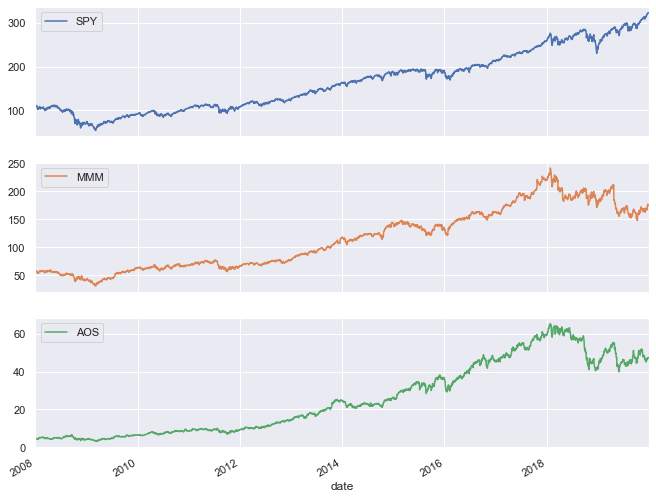

In [96]:
stock_names = stocks.columns.tolist()
axes = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

First thing to notice is not all stocks have data for the full date range.  Since we need a full dataset to train, we will delete these stocks.

In [97]:
# Here are the stocks with NAN values.  Make sure this matches the plots above.
print(stocks.columns[stocks.isna().any()])
print("\nThere are {} stocks that lack data.".format(sum(stocks.isna().any())))

Index([], dtype='object')

There are 0 stocks that lack data.


In [98]:
# Now we delete the imcomplete stocks
stocks = stocks.loc[:, ~stocks.isna().any()]
stocks.shape

(3022, 3)

If you see any data with drop outs, you may wish to reload to see if the source is defective or if there was an issue in the download.  
I will also 'fill' any missing data with a linear interpolation.

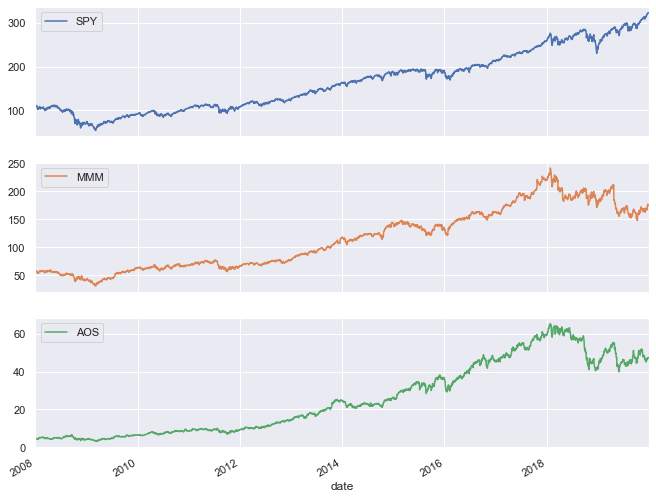

In [99]:
stocks = stocks.replace(0, np.nan).interpolate()
_ = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

**Now that's a pretty dataset!!!**

## 4. Create technical analysis signals
Here we will extract the signals used in some classical technical analysis strategies and use them as input to our Reinforcement Learning model.

### Simple 20-Day Moving Average (SMA20)
A standard strategy is to buy when the price crosses the 20-day SMA from below and sell when it crosses from above.
Therefore we need to calculate the 20-day SMA and determine the crosses from above and below.  There is also a slight time delay since on day t when we can trade we do not know the closing price for that day.

In [100]:
sma20 = stocks.rolling(window=20).mean().iloc[19:]

Make a pretty plot to verify calculation.

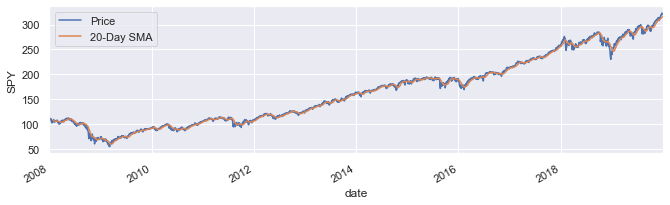

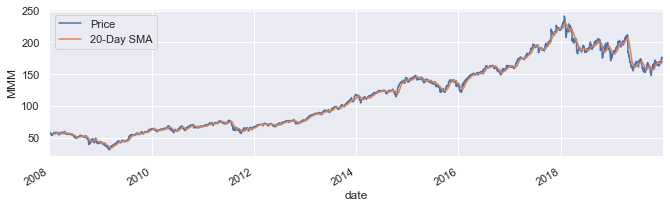

In [101]:
for s in stock_names[:2]:
    ax = stocks.loc[:, s].plot(figsize=(11, 3), label="Price")
    _ = sma20.loc[:, s].plot(ax=ax, label="20-Day SMA")
    ax.set_ylabel(s)
    plt.legend()
    plt.show()

Let's do it again but zoomed this time.

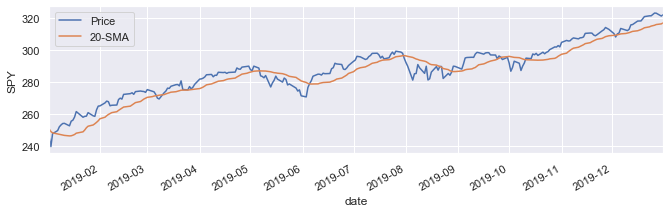

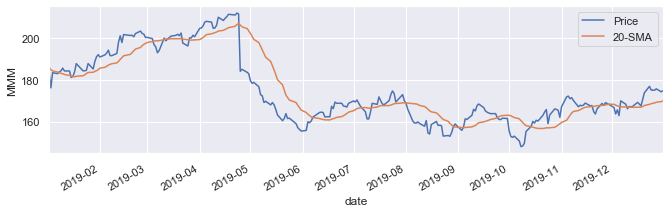

In [102]:
for s in stock_names[:2]:
    ax = stocks.loc['2019-01-01':, s].plot(figsize=(11, 3), label="Price")
    _ = sma20.loc['2019-01-01':, s].plot(ax=ax, label="20-SMA")
    ax.set_ylabel(s)
    plt.legend()
    plt.show()

#### So the SMA looks good, now detect the cross overs
We will use the following convention:    
*  0 = no crossing    
* +1 = price crossing from below (buy)
* -1 = price crossing from above (sell)

In [109]:
# Initialize to zero (no crossing)
sma20_crosses = sma20.iloc[1:, :].copy(deep=True)
sma20_crosses.loc[:, :] = 0

# Determine the deltas for the previous 2 days and any crosses
deltas = (sma20.iloc[1:, :] - stocks.iloc[20:, :]).values
crosses = deltas[:-1] * deltas[1:] <= 0
for s in range(len(stock_names)):
    for d in range(1, deltas.shape[0]):
        if crosses[d-1, s]:
            if deltas[d, s] >= 0:
                sma20_crosses.iloc[d, s] = -1
            else:
                sma20_crosses.iloc[d, s] = 1
sma20_crosses.replace(False, 0, inplace=True)

As always make a pretty plot.

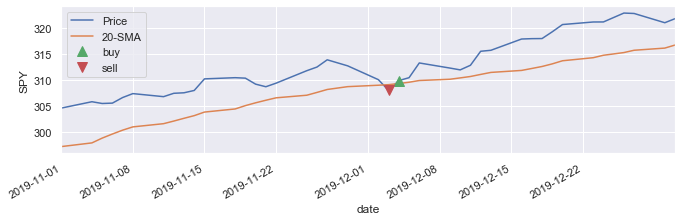

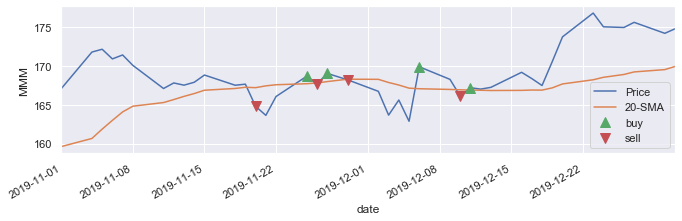

In [110]:
start = '2019-11-01'
for s in stock_names[:2]:
    ax = stocks.loc[start:, s].plot(figsize=(11, 3), label="Price")
    _ = sma20.loc[start:, s].plot(ax=ax, label="20-SMA")
    
    tmp = sma20_crosses.loc[start:, s]
    buy  = tmp.loc[tmp > 0]
    sell = tmp.loc[tmp < 0]
    ax.plot(buy.index, stocks.loc[buy.index, s], '^', markersize=10, color='g', label='buy')
    ax.plot(sell.index, stocks.loc[sell.index, s], 'v', markersize=10, color='r', label='sell')

    ax.set_ylabel(s)
    plt.legend()
    plt.show()

#### Let's repeat for the 100-Day SMA

In [113]:
sma100 = stocks.rolling(window=100).mean().iloc[99:]

# Initialize to zero (no crossing)
sma100_crosses = sma100.iloc[1:, :].copy(deep=True)
sma100_crosses.loc[:, :] = 0

# Determine the deltas for the previous 2 days and any crosses
deltas = (sma100.iloc[1:, :] - stocks.iloc[100:, :]).values
crosses = deltas[:-1] * deltas[1:] <= 0
for s in range(len(stock_names)):
    for d in range(1, deltas.shape[0]):
        if crosses[d-1, s]:
            if deltas[d, s] >= 0:
                sma100_crosses.iloc[d, s] = -1
            else:
                sma100_crosses.iloc[d, s] = 1
sma100_crosses.replace(False, 0, inplace=True)

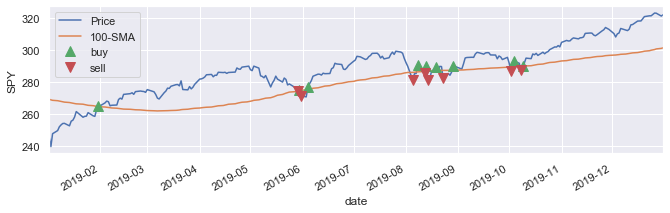

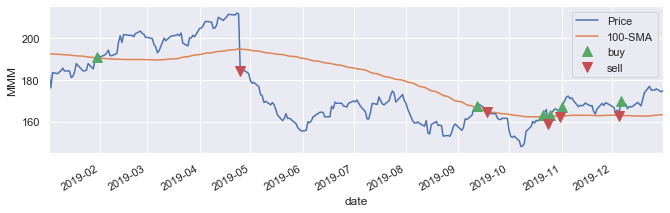

In [114]:
start = '2019-01-01'
for s in stock_names[:2]:
    ax = stocks.loc[start:, s].plot(figsize=(11, 3), label="Price")
    _ = sma100.loc[start:, s].plot(ax=ax, label="100-SMA")
    
    tmp = sma100_crosses.loc[start:, s]
    buy  = tmp.loc[tmp > 0]
    sell = tmp.loc[tmp < 0]
    ax.plot(buy.index, stocks.loc[buy.index, s], '^', markersize=10, color='g', label='buy')
    ax.plot(sell.index, stocks.loc[sell.index, s], 'v', markersize=10, color='r', label='sell')

    ax.set_ylabel(s)
    plt.legend()
    plt.show()

### Moving Average Convergence/Divergence (MACD)
The MACD compares 3 different Exponential Moving Averages (EMA); the 12 and 26 day EMA on the stock price plus the 9 day EMA on the difference between the 1st two.  The difference is called the MACD and the EMA of the difference is called the signal.  Similar to the SMA signals above, when the MACD and signal cross we create buy/sell signals as follows.

*  0 = no cross detected
* +1 = MACD crosses from below (buy)
* -1 = MACD crosses from above (sell)

In [115]:
macd = stocks.ewm(span=12, adjust=False).mean() - stocks.ewm(span=26, adjust=False).mean()
macd_signal = macd.ewm(span=9, adjust=False).mean()

Let's detect cross overs.

In [122]:
# Initialize to zero (no crossing)
macd_crosses = macd.iloc[1:, :].copy(deep=True)
macd_crosses.loc[:, :] = 0

# Determine the deltas for the previous 2 days and any crosses
deltas = (macd.iloc[1:, :] - macd_signal.iloc[1:, :]).values
crosses = deltas[:-1] * deltas[1:] <= 0
for s in range(len(stock_names)):
    for d in range(1, deltas.shape[0]):
        if crosses[d-1, s]:
            if deltas[d, s] >= 0:
                macd_crosses.iloc[d, s] = -1
            else:
                macd_crosses.iloc[d, s] = 1
macd_crosses.replace(False, 0, inplace=True)

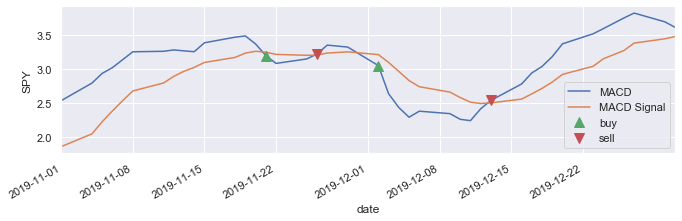

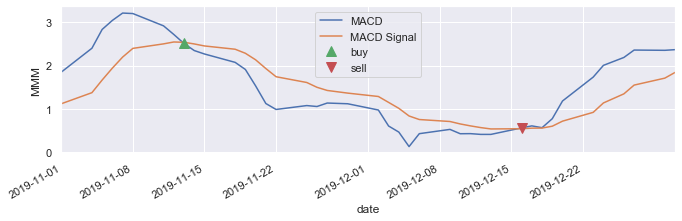

In [125]:
start = '2019-11-01'
for s in stock_names[:2]:
    ax = macd.loc[start:, s].plot(figsize=(11, 3), label="MACD")
    _ = macd_signal.loc[start:, s].plot(ax=ax, label="MACD Signal")
    
    tmp = macd_crosses.loc[start:, s]
    buy  = tmp.loc[tmp > 0]
    sell = tmp.loc[tmp < 0]
    ax.plot(buy.index, macd.loc[buy.index, s], '^', markersize=10, color='g', label='buy')
    ax.plot(sell.index, macd.loc[sell.index, s], 'v', markersize=10, color='r', label='sell')

    ax.set_ylabel(s)
    plt.legend()
    plt.show()

### Relative Strength Index (RSI)
Th relative strength index is a momentum oscillator that measures the velocity and magnitude of directional price movements.  Usually it is measured from 0 to 100 with a low or high number indicating under or over sold respectively.  Usually the trader would a lower and upper limit, which would trigger a buy or sell when crossed from the center.  Since this limit is specific to the trader, we will use a continuous normalized RSI value without buy/sell signals.  To help in training it will be normalized to -1 to 1 instead of 0 to 100.

In [132]:
# First calculte the upward and downward movements
delta = stocks.diff()
up, down = delta.copy(), delta.copy()
up[delta < 0] = 0.0
down[delta > 0] = 0.0

# Now calculate the average up and down movements of the last 14 days
up = up.rolling(14).mean()
down = down.rolling(14).mean().abs()

# Then calculate the modified RSI
rsi = 1 - 2 /(1 + up/down)
rsi.describe()

,SPY,MMM,AOS
count,3008.000000,3008.000000,3008.000000
mean,0.132025,0.081943,0.087673
std,0.327985,0.335573,0.334015
min,-0.920157,-0.920502,-0.817978
25%,-0.108017,-0.146265,-0.145318
50%,0.131951,0.096806,0.101558
75%,0.357168,0.310040,0.329227
max,1.000000,0.938866,0.920318


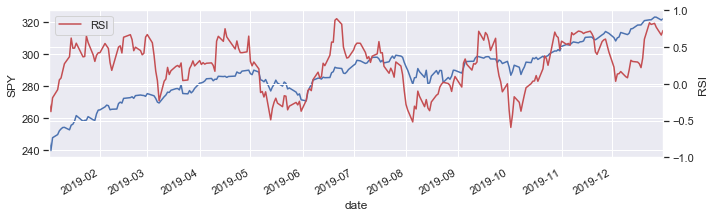

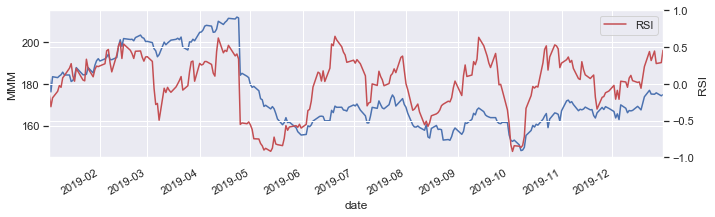

In [138]:
start = '2019-01-01'
for s in stock_names[:2]:
    ax = stocks.loc[start:, s].plot(figsize=(11, 3), label="Price")
    ax2 = ax.twinx()
    _ = rsi.loc[start:, s].plot(ax=ax2, label="RSI", c='r')
    
    ax.set_ylabel(s)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(-1, 1)
    plt.legend()
    plt.show()

In [107]:
# Calculate the log returns and clip to -1 and 1
actual_returns = {}
cleaned_returns = {}
for dt in settings['prediction_days']:
    actual_returns[dt] = (np.log(stocks) - np.log(stocks.shift(dt))).clip(-1, 1)
    x = actual_returns[dt].to_numpy().flatten()
    cleaned_returns[dt] = x[~np.isnan(x)]

### Determine the classification demarkations

### Awesome, we now have the classifications for training!
Last step will be to save this data in a clean format for the next notebook to use.

First we have to clip the training data at the end by max(dt) so that we can have a full set of classifications.  We will also have to clip the begining my min(dt) to allow for the return calculation.

We will also be using the returns with the smallest dt values are the training data input.  We use returns instead of the raw stock prices to ensure we have stationary timeseries data.  Consider a stock that is \\$10 to \\$20 over the training period but grows above \\$20 during the prediction.  The model will be seeing new data and will be extrapolating.  Also when we standardize the data, the mean and standard deviation of the returns will be much more meaningful.

We will be using the smallest dt value since these data contains more information than returns based on larger dt values.  We could you multiple dt values as input but it would be repeating information and adding complexity.

Lastly we need to save the mean and standard deviation data to standardize any new data that we receive.

In [108]:
# First lets clip all the data to the same end date for a full training dataset
start = stocks.index[max(settings['prediction_days'])]
end = stocks.index[-max(settings['prediction_days'])-1]
classification_clipped = {}
returns_clipped = {}
stats = {}
for dt in settings['prediction_days']:
    classification_clipped[dt] = classification[dt].loc[start:end, :]
    returns_clipped[dt] = actual_returns[dt].loc[start:end, :]
    
    # Also normalized the input
    stats[dt] = returns_clipped[dt].describe().loc[['mean', 'std'], :]
    returns_clipped[dt] = (returns_clipped[dt] - stats[dt].loc['mean', :]) / stats[dt].loc['std', :]

NameError: name 'classification' is not defined

In [ ]:
# And finally save the data for the next training notebook
with open('training-data-raw.pkl', 'wb') as f:
    pickle.dump({'stats': stats, 'x': returns_clipped, 'y':classification_clipped}, 
                f, protocol=pickle.HIGHEST_PROTOCOL)